In [42]:
import random
from typing import Callable, Optional, TypedDict
import numpy as np
from obp.dataset import SyntheticBanditDataset
from obp.ope import ReplayMethod, InverseProbabilityWeighting
import polars as pl

In [43]:
class BanditFeedbackDict(TypedDict):
    n_rounds: int  # ラウンド数
    n_actions: int  # アクション数s
    context: np.ndarray  # 文脈 (shape: (n_rounds, dim_context))
    action_context: (
        np.ndarray
    )  # アクション特徴量 (shape: (n_actions, dim_action_features))
    action: np.ndarray  # 実際に選択されたアクション (shape: (n_rounds,))
    position: Optional[np.ndarray]  # ポジション (shape: (n_rounds,) or None)
    reward: np.ndarray  # 報酬 (shape: (n_rounds,))
    expected_reward: np.ndarray  # 期待報酬 (shape: (n_rounds, n_actions))
    pi_b: np.ndarray  # データ収集方策 P(a|x) (shape: (n_rounds, n_actions))
    pscore: np.ndarray  # 傾向スコア (shape: (n_rounds,))

In [44]:
# 真の期待報酬関数 E_{p(r|x,a)}[r] を定義する
def expected_reward_function(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """(アクションa, 文脈x)の各組み合わせに対する期待報酬 E_{p(r|x,a)}[r] を定義する関数
    今回の場合は、推薦候補4つの記事を送った場合の報酬rの期待値を、文脈xに依存しない固定値として設定する
    ニュース0: 0.2, ニュース1: 0.15, ニュース2: 0.1, ニュース3: 0.05
    返り値のshape: (n_rounds, n_actions, len_list)
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 固定の期待報酬を設定 (n_actions=4として固定値を設定)
    fixed_rewards = np.array([0.4, 0.3, 0.2, 0.2])

    # 文脈の数だけ期待報酬を繰り返して返す
    return np.tile(fixed_rewards, (n_rounds, 1))


# 試しに期待報酬関数を実行してみる
n_rounds = 3
n_actions = 4
context = np.array([[1], [2], [3]])
action_context = np.array([[1], [2], [3], [4]])
print(expected_reward_function(context, action_context))

[[0.4 0.3 0.2 0.2]
 [0.4 0.3 0.2 0.2]
 [0.4 0.3 0.2 0.2]]


In [45]:
# 5種類の推薦方策を定義していく


from typing import Literal


def pi_1(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """コンテキストを考慮せず、全てのユーザに対してニュース $a_0$ を確率1で推薦する決定的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    p_scores = np.array([1.0, 0.0, 0.0, 0.0])
    action_dist = np.tile(p_scores, (n_rounds, 1))

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_2(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """コンテキストを考慮せず、全てのユーザに対してニュース $a_1$ を確率1で推薦する決定的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    p_scores = np.array([0.0, 1.0, 0.0, 0.0])
    action_dist = np.tile(p_scores, (n_rounds, 1))

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_3(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """コンテキストを考慮せず、全てのユーザに対してニュース $a_0$ を確率0.4、
    ニュース $a_1$ を確率0.3、ニュース $a_2$ を確率0.2、ニュース $a_3$ を確率0.1で
    推薦する確率的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    p_scores = np.array([0.4, 0.3, 0.2, 0.1])
    action_dist = np.tile(p_scores, (n_rounds, 1))

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_4(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """ユーザとニュースのコンテキストを考慮し、
    コンテキストベクトル $x$ とアイテムコンテキストベクトル $e$ の内積が最も大きいニュースを
    確率1で推薦する決定的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 内積を計算
    scores = context @ action_context.T  # shape: (n_rounds, n_actions)

    # 各ラウンドで最もスコアが高いアクションのindexを取得
    selected_actions = np.argmax(scores, axis=1)  # shape: (n_rounds,)

    # 決定的方策: 確率1で最もスコアが高いアクションを選択
    action_dist = np.zeros((n_rounds, n_actions))
    action_dist[np.arange(n_rounds), selected_actions] = 1.0

    return action_dist


def pi_5(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """ユーザとニュースのコンテキストを考慮し、
    コンテキストベクトル $x$ とアイテムコンテキストベクトル $e$ の内積が最も大きいニュースを
    確率0.7で推薦し、その他のニュースを均等に確率0.1で推薦する確率的方策。
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 内積を計算
    scores = context @ action_context.T  # shape: (n_rounds, n_actions)

    # 各ラウンドで最もスコアが高いアクションのindexを取得
    selected_actions = np.argmax(scores, axis=1)  # shape: (n_rounds,)

    # 確率的方策: 確率0.4で全てのアクションを一様ランダムに選択し、確率0.6で最もスコアが高いアクションを決定的に選択
    epsilon = 0.4
    action_dist = np.full((n_rounds, n_actions), epsilon / n_actions)
    action_dist[np.arange(n_rounds), selected_actions] = (
        1.0 - epsilon + epsilon / n_actions
    )
    return action_dist


print(
    pi_5(
        context=np.array([[1], [2], [3]]),
        action_context=np.array([[1], [2], [3], [4]]),
    )
)

[[0.1 0.1 0.1 0.7]
 [0.1 0.1 0.1 0.7]
 [0.1 0.1 0.1 0.7]]


In [46]:
def policy_wrapper(
    base_policy: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    mode: Literal["logging_poicy", "target_policy_name"],
) -> Callable[[np.ndarray, np.ndarray, int], np.ndarray]:
    """
    方策のラッパー関数。データ収集時と評価時で出力の形状を切り替える。
    (logging_policyの場合はshape=(n_rounds, n_actions)、target_policyの場合はshape=(n_rounds,n_actions, 1))
    Parameters
    - base_policy: ベースとなる方策関数
    - mode: 方策のモード。"logging_policy"はデータ収集方策、"target_policy"は評価方策

    Returns
    - wrapされた方策関数
    """

    def wrapped_policy(
        context: np.ndarray,
        action_context: np.ndarray,
        random_state: int = None,
    ) -> np.ndarray:
        action_dist = base_policy(context, action_context, random_state)
        if mode == "logging_policy":
            return action_dist
        elif mode == "target_policy":
            return action_dist[:, :, np.newaxis]

    return wrapped_policy


target_policy_name = policy_wrapper(pi_5, mode="target_policy")
print(target_policy_name(context, action_context))
print(target_policy_name(context, action_context).shape)

[[[0.1]
  [0.1]
  [0.1]
  [0.7]]

 [[0.1]
  [0.1]
  [0.1]
  [0.7]]

 [[0.1]
  [0.1]
  [0.1]
  [0.7]]]
(3, 4, 1)


In [49]:
def run_single_ope_simulation(
    simulate_idx: int,
    n_rounds: int,
    n_actions: int,
    dim_context: int,
    action_context: np.ndarray,
    reward_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    logging_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    target_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
) -> dict:
    # データ収集方策によって集められるはずの、擬似バンディットデータの設定を定義
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_function,
        behavior_policy_function=logging_policy_function,
        random_state=simulate_idx,
        action_context=action_context,
    )
    # 収集されるバンディットフィードバックデータを生成
    bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

    # bandit_feedbackをpl.DataFrameに変換
    selected_action_contexts = action_context[bandit_feedback["action"], :]
    bandit_feedback_df = pl.DataFrame(
        {
            "time_step": [i for i in range(n_rounds)],
            "context": bandit_feedback["context"].tolist(),
            "action": bandit_feedback["action"].tolist(),
            "action_context": selected_action_contexts.tolist(),
            "reward": bandit_feedback["reward"].tolist(),
            "p_score": bandit_feedback["pscore"].tolist(),
        }
    )

    # 評価方策を使って、ログデータ(bandit_feedback)に対する行動選択確率を計算
    # target_policy_action_dist = target_policy_1(
    #     context=bandit_feedback["context"],
    #     action_context=bandit_feedback["action_context"],
    #     recommend_arm_idx=0,
    # )
    target_policy_action_dist = target_policy_function(
        context=bandit_feedback["context"],
        action_context=bandit_feedback["action_context"],
    )
    # 真の期待報酬E_{p(r|x,a)}[r]を使って、データ収集方策の代わりに評価方策を動かした場合の性能を計算
    ground_truth_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback["expected_reward"],
        action_dist=target_policy_action_dist,
    )

    # OPE推定量を準備(naive推定量とIPS推定量)
    naive_estimator = ReplayMethod()
    ips_estimator = InverseProbabilityWeighting()

    # それぞれのOPE推定量を使って、データ収集方策の代わりに評価方策を動かした場合の価値を推定
    estimated_policy_value_by_naive = naive_estimator.estimate_policy_value(
        reward=bandit_feedback["reward"],
        action=bandit_feedback["action"],
        action_dist=target_policy_action_dist,
    )
    estimated_policy_value_by_ips = ips_estimator.estimate_policy_value(
        action=bandit_feedback["action"],
        reward=bandit_feedback["reward"],
        action_dist=target_policy_action_dist,
        pscore=bandit_feedback["pscore"],
    )

    return {
        "simulate_idx": simulate_idx,
        "ground_truth_policy_value": ground_truth_policy_value,
        "estimated_policy_value_by_naive": estimated_policy_value_by_naive,
        "estimated_policy_value_by_ips": estimated_policy_value_by_ips,
    }


# シミュレーションの設定
simulate_idx = 0
n_rounds = 5
n_actions = 4
dim_context = 3
action_context = np.random.random((n_actions, dim_context))
reward_function = expected_reward_function
logging_policy_function = policy_wrapper(pi_3, mode="logging_policy")
target_policy_function = policy_wrapper(pi_3, mode="target_policy")

# シミュレーションを実行
result_dict = run_single_ope_simulation(
    simulate_idx=simulate_idx,
    n_rounds=n_rounds,
    n_actions=n_actions,
    dim_context=dim_context,
    action_context=action_context,
    reward_function=reward_function,
    logging_policy_function=logging_policy_function,
    target_policy_function=target_policy_function,
)
print(result_dict)

{'simulate_idx': 0, 'ground_truth_policy_value': 0.3100000000000001, 'estimated_policy_value_by_naive': 0.0, 'estimated_policy_value_by_ips': 0.4}


In [ ]:
import itertools

from pandera.polars import DataFrameSchema
from pandera.typing.polars import DataFrame


class SimulationResult(DataFrameSchema):
    データ収集方策名: str
    評価方策名: str
    真の性能: float
    naive推定値: float
    naive誤差: float
    ips推定値: float
    ips誤差: float


# 5つの推薦方策について、データ収集方策と評価方策の組み合わせを作って、シミュレーションを実行する


# シミュレーションの設定
def run_multiple_simulations(
    policy_map: dict[str, Callable[[np.ndarray, np.ndarray, int], np.ndarray]],
    n_rounds: int = 10000,
    n_actions: int = 4,
    dim_context: int = 3,
    action_context: np.ndarray = np.random.random((n_actions, dim_context)),
) -> DataFrame[SimulationResult]:
    # policiesから重複を許して2つの方策の組み合わせを作成
    policy_combinations = list(itertools.product(policy_map.keys(), repeat=2))

    results = []
    for logging_policy_name, target_policy_name in policy_combinations:
        # データ収集方策と評価方策を指定して、シミュレーションを実行
        result_dict = run_single_ope_simulation(
            simulate_idx=0,
            n_rounds=n_rounds,
            n_actions=n_actions,
            dim_context=dim_context,
            action_context=action_context,
            reward_function=expected_reward_function,
            logging_policy_function=policy_wrapper(
                policy_map[logging_policy_name], mode="logging_policy"
            ),
            target_policy_function=policy_wrapper(
                policy_map[target_policy_name], mode="target_policy"
            ),
        )
        results.append(
            {
                "データ収集方策名": logging_policy_name,
                "評価方策名": target_policy_name,
                "真の性能": result_dict["ground_truth_policy_value"],
                "naive推定値": result_dict["estimated_policy_value_by_naive"],
                "naive誤差": result_dict["estimated_policy_value_by_naive"]
                - result_dict["ground_truth_policy_value"],
                "ips推定値": result_dict["estimated_policy_value_by_ips"],
                "ips誤差": result_dict["estimated_policy_value_by_ips"]
                - result_dict["ground_truth_policy_value"],
            }
        )
    return pl.DataFrame(results)


policy_map = {
    "pi_1": pi_1,
    "pi_2": pi_2,
    "pi_3": pi_3,
    "pi_4": pi_4,
    "pi_5": pi_5,
}
result_df = run_multiple_simulations(policy_map)
print(result_df)

shape: (25, 7)
┌──────────────────┬────────────┬──────────┬─────────────┬───────────┬───────────┬───────────┐
│ データ収集方策名 ┆ 評価方策名 ┆ 真の性能 ┆ naive推定値 ┆ naive誤差 ┆ ips推定値 ┆ ips誤差   │
│ ---              ┆ ---        ┆ ---      ┆ ---         ┆ ---       ┆ ---       ┆ ---       │
│ str              ┆ str        ┆ f64      ┆ f64         ┆ f64       ┆ f64       ┆ f64       │
╞══════════════════╪════════════╪══════════╪═════════════╪═══════════╪═══════════╪═══════════╡
│ pi_1             ┆ pi_1       ┆ 0.4      ┆ 0.4002      ┆ 0.0002    ┆ 0.4002    ┆ 0.0002    │
│ pi_1             ┆ pi_2       ┆ 0.3      ┆ 0.0         ┆ -0.3      ┆ 0.0       ┆ -0.3      │
│ pi_1             ┆ pi_3       ┆ 0.31     ┆ 0.0         ┆ -0.31     ┆ 0.16008   ┆ -0.14992  │
│ pi_1             ┆ pi_4       ┆ 0.2739   ┆ 0.399844    ┆ 0.125944  ┆ 0.1028    ┆ -0.1711   │
│ pi_1             ┆ pi_5       ┆ 0.27434  ┆ 0.0         ┆ -0.27434  ┆ 0.1017    ┆ -0.17264  │
│ …                ┆ …          ┆ …        ┆ …           ┆ …  

In [36]:
# 小数点以下4桁までに丸める
rounded_result_df = result_df.with_columns(
    result_df["真の性能"].round(3),
    result_df["naive推定値"].round(3),
    result_df["naive誤差"].round(3),
    result_df["ips推定値"].round(3),
    result_df["ips誤差"].round(3),
)
display(rounded_result_df)

# 結果をcsvファイルに保存
rounded_result_df.write_csv("result.csv")

データ収集方策名,評価方策名,真の性能,naive推定値,naive誤差,ips推定値,ips誤差
str,str,f64,f64,f64,f64,f64
"""pi_1""","""pi_1""",0.4,0.4,0.0,0.4,0.0
"""pi_1""","""pi_2""",0.3,0.0,-0.3,0.0,-0.3
"""pi_1""","""pi_3""",0.31,0.0,-0.31,0.16,-0.15
"""pi_1""","""pi_4""",0.274,0.4,0.126,0.103,-0.171
"""pi_1""","""pi_5""",0.274,0.0,-0.274,0.102,-0.173
…,…,…,…,…,…,…
"""pi_5""","""pi_1""",0.4,0.419,0.019,0.441,0.041
"""pi_5""","""pi_2""",0.3,0.294,-0.006,0.321,0.021
"""pi_5""","""pi_3""",0.31,0.0,-0.31,0.332,0.022


/var/folders/6y/cj2xghkd0hd0yqsf9kh4hjyr0000gq/T/ipykernel_50648/3307068461.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(x_labels, rotation=45)
/var/folders/6y/cj2xghkd0hd0yqsf9kh4hjyr0000gq/T/ipykernel_50648/3307068461.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(x_labels, rotation=45)
/Users/masato.morita/Library/Caches/pypoetry/virtualenvs/recommender-experiments-_FVBVT8O-py3.10/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/masato.morita/Library/Caches/pypoetry/virtualenvs/recommender-experiments-_FVBVT8O-py3.10/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 23450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/masato.morita/Library/Caches/pypoetry/virtualenvs/recommender-e

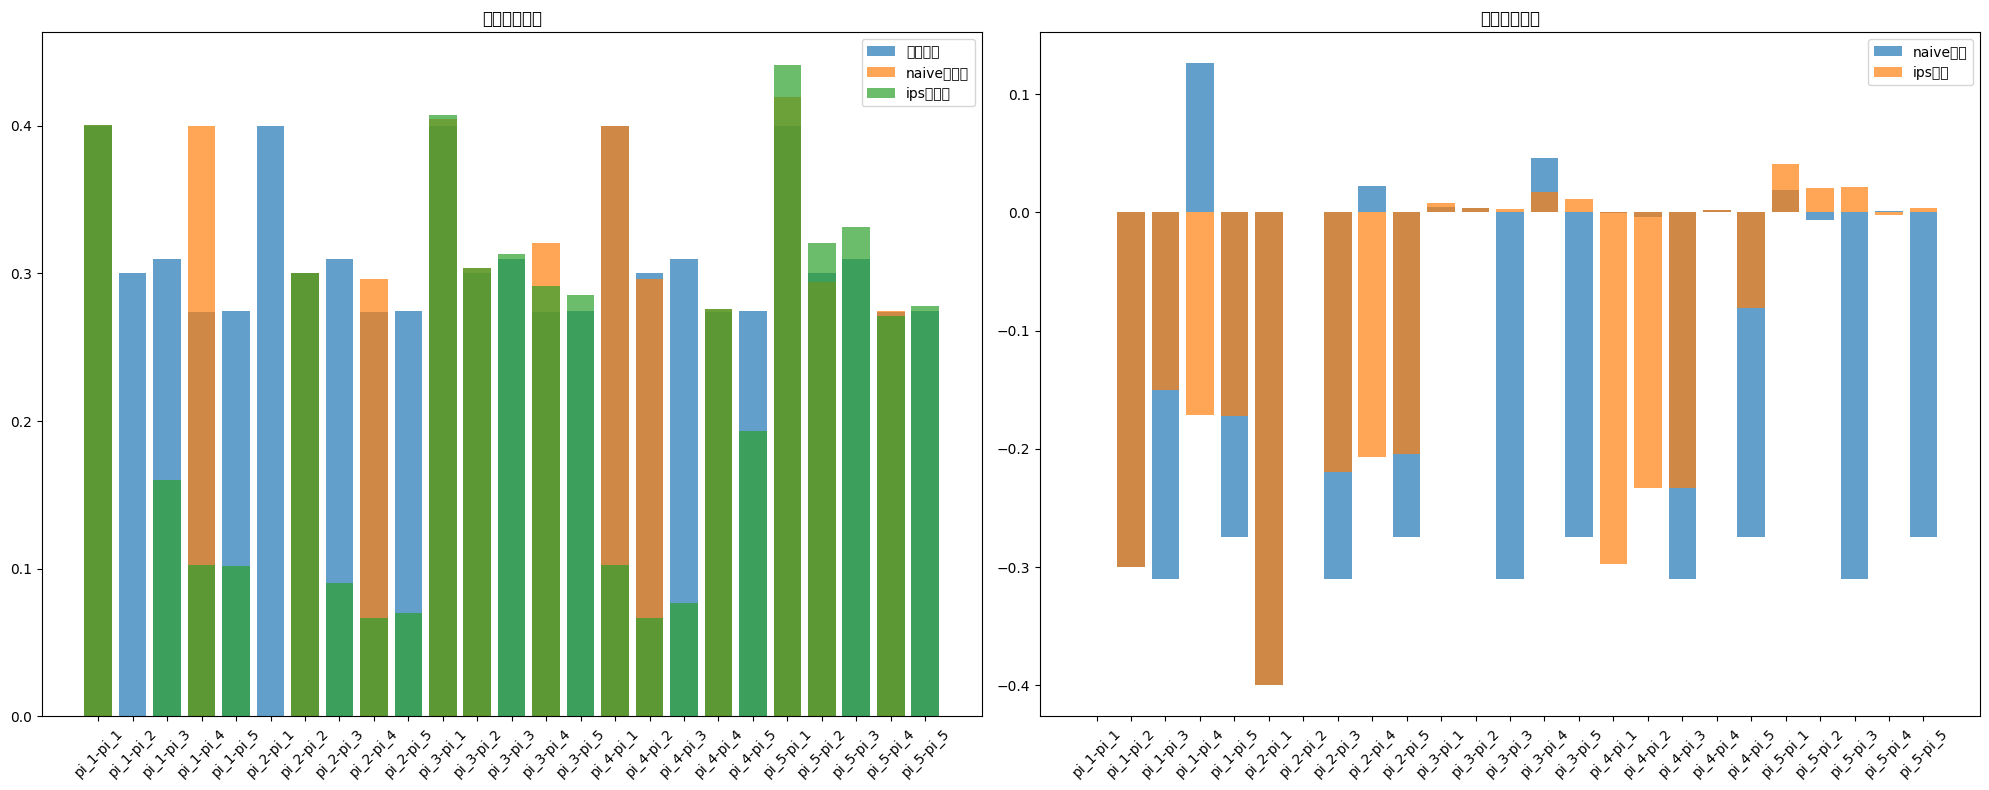

In [ ]:
# 結果を可視化する
import matplotlib.pyplot as plt

# X軸=方策の組み合わせ、y軸にnaive誤差とips誤差を取り、それぞれの値を棒グラフで表示
# それぞれの値を棒グラフで表示

# polars DataFrameをdictに変換してmatplotlibに渡す
x_labels = result_df.select(["データ収集方策名", "評価方策名"]).to_numpy().tolist()
x_labels = [
    f"{d[0]}-{d[1]}" for d in x_labels
]  # ラベルを "収集方策-評価方策" にまとめる

# グラフ用のデータ抽出
true_values = result_df["真の性能"].to_list()
naive_values = result_df["naive推定値"].to_list()
ips_values = result_df["ips推定値"].to_list()
naive_errors = result_df["naive誤差"].to_list()
ips_errors = result_df["ips誤差"].to_list()

# グラフの描画
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 推定値の比較
axes[0].bar(x_labels, true_values, label="真の性能", alpha=0.7)
axes[0].bar(x_labels, naive_values, label="naive推定値", alpha=0.7)
axes[0].bar(x_labels, ips_values, label="ips推定値", alpha=0.7)
axes[0].set_title("推定値の比較")
axes[0].legend()
axes[0].set_xticklabels(x_labels, rotation=45)

# 誤差の比較
axes[1].bar(x_labels, naive_errors, label="naive_error", alpha=0.7)
axes[1].bar(x_labels, ips_errors, label="ips_error", alpha=0.7)
axes[1].set_title("推定値の誤差")
axes[1].legend()
axes[1].set_xticklabels(x_labels, rotation=45)

# グラフ表示
plt.tight_layout()
plt.show()

In [ ]:
def run_single_ope_simulation(
    simulate_idx: int,
    n_rounds: int,
    n_actions: int,
    dim_context: int,
    action_context: np.ndarray,
    reward_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    logging_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    target_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
) -> dict:
    # データ収集方策によって集められるはずの、擬似バンディットデータの設定を定義
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_function,
        behavior_policy_function=logging_policy_function,
        random_state=simulate_idx,
        action_context=action_context,
    )
    # 収集されるバンディットフィードバックデータを生成
    bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

    # bandit_feedbackをpl.DataFrameに変換
    selected_action_contexts = action_context[bandit_feedback["action"], :]
    bandit_feedback_df = pl.DataFrame(
        {
            "time_step": [i for i in range(n_rounds)],
            "context": bandit_feedback["context"].tolist(),
            "action": bandit_feedback["action"].tolist(),
            "action_context": selected_action_contexts.tolist(),
            "reward": bandit_feedback["reward"].tolist(),
            "p_score": bandit_feedback["pscore"].tolist(),
        }
    )

    # 評価方策を使って、ログデータ(bandit_feedback)に対する行動選択確率を計算
    # target_policy_action_dist = target_policy_1(
    #     context=bandit_feedback["context"],
    #     action_context=bandit_feedback["action_context"],
    #     recommend_arm_idx=0,
    # )
    target_policy_action_dist = target_policy_function(
        context=bandit_feedback["context"],
        action_context=bandit_feedback["action_context"],
    )
    # 真の期待報酬E_{p(r|x,a)}[r]を使って、データ収集方策の代わりに評価方策を動かした場合の性能を計算
    ground_truth_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback["expected_reward"],
        action_dist=target_policy_action_dist,
    )

    # OPE推定量を準備(naive推定量とIPS推定量)
    naive_estimator = ReplayMethod()
    ips_estimator = InverseProbabilityWeighting()

    # それぞれのOPE推定量を使って、データ収集方策の代わりに評価方策を動かした場合の価値を推定
    estimated_policy_value_by_naive = naive_estimator.estimate_policy_value(
        reward=bandit_feedback["reward"],
        action=bandit_feedback["action"],
        action_dist=target_policy_action_dist,
    )
    estimated_policy_value_by_ips = ips_estimator.estimate_policy_value(
        action=bandit_feedback["action"],
        reward=bandit_feedback["reward"],
        action_dist=target_policy_action_dist,
        pscore=bandit_feedback["pscore"],
    )

    return {
        "simulate_idx": simulate_idx,
        "ground_truth_policy_value": ground_truth_policy_value,
        "estimated_policy_value_by_naive": estimated_policy_value_by_naive,
        "estimated_policy_value_by_ips": estimated_policy_value_by_ips,
    }


# シミュレーションの設定
simulate_idx = 0
n_rounds = 10000
n_actions = 4
dim_context = 3
action_context = np.random.random((n_actions, dim_context))
reward_function = expected_reward_function
logging_policy_function = policy_wrapper(pi_3, mode="logging_policy")
target_policy_function = policy_wrapper(pi_3, mode="target_policy")

# シミュレーションを実行
result_dict = run_single_ope_simulation(
    simulate_idx=simulate_idx,
    n_rounds=n_rounds,
    n_actions=n_actions,
    dim_context=dim_context,
    action_context=action_context,
    reward_function=reward_function,
    logging_policy_function=logging_policy_function,
    target_policy_function=target_policy_function,
)
print(result_dict)